In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df=pd.read_csv("Data/ATVI.csv",parse_dates=["Date"],index_col="Date")


In [3]:

df2 = df.iloc[-90:]
df_1 = pd.date_range(start=df2.index[-1] + pd.Timedelta(days=1), periods=5)
df_3 = pd.date_range(start=df2.index[-1] + pd.Timedelta(days=1), end=df_1[-1])
df2_sliced = df2.tail(5)

next_df = pd.DataFrame({
    "Open": df2_sliced["Open"].values,
    "High": df2_sliced["High"].values,
    "Low": df2_sliced["Low"].values,
    "Close": df2_sliced["Close"].values,
    "Adj Close": df2_sliced["Adj Close"].values,
    "Volume": df2_sliced["Volume"].values
}, index=df_1)

In [4]:
df=pd.concat([df,next_df])
df.columns=df.columns.str.lower()

In [5]:
df["target"]=df["close"].shift(-1).ffill()
filt=df.columns.isin(["adj close","target","low","close"])
predictors=df.columns[~filt]
X=df[predictors]
y=df["target"]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error
R=LinearRegression()
def backtest(data,model,predictors,start=100,step=90):
    all_predictors=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i]
        test=data.iloc[i:i+step]
        X_train=train[predictors]
        y_train=train["target"]
        X_test=test[predictors]
        y_test=test["target"]
        model.fit(X_train,y_train)
        preds=model.predict(X_test)
        preds=pd.Series(preds,index=test.index)
        Combined=pd.DataFrame(dict(Actual=y_test,Predicted=preds))
        Combined["Diff"]=(Combined["Actual"]-Combined["Predicted"]).abs()
        all_predictors.append(Combined)       
    return pd.concat(all_predictors)


In [7]:
Combined=backtest(df,R,predictors)

In [8]:
Combined
acc=r2_score(Combined["Actual"],Combined["Predicted"])

In [9]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=sm.add_constant(X)
result=sm.OLS(y,x).fit()

vif=pd.DataFrame(dict({"vif":[variance_inflation_factor(x.values,i)for i in range(x.shape[1])],"features":x.columns}))

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     2761.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):          2.17e-192
Time:                        13:18:24   Log-Likelihood:                -404.75
No. Observations:                 256   AIC:                             817.5
Df Residuals:                     252   BIC:                             831.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5918      0.923     -0.641      0.522      -2.410       1.227
open           0.1492      0.115      1.301      0.194      -0.077       0.375
high           0.8551      0.117      7.296      0.000       0.624       1.086
volume     -1.148e-08   1.16e-08     -0.992      0.322   -3.43e-08    1.13e-08
==============================================================================
Omnibus:                      118.895   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7644.368
Skew:                          -0.926   Prob(JB):                         0.00
Kurtosis:                      29.706   Cond. No.                     1.37e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

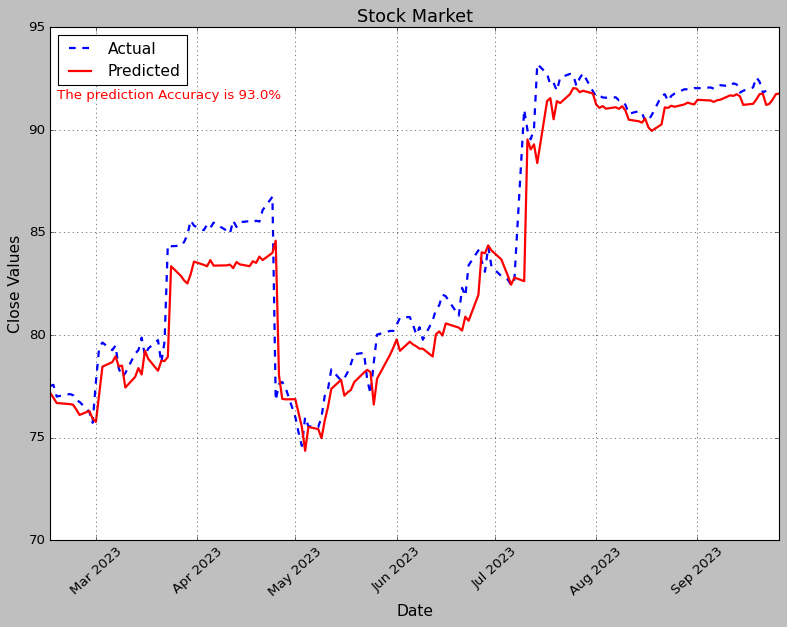

In [11]:
import matplotlib.pyplot as plt
from datetime import datetime
current_date=datetime.now()
DATE=current_date.strftime("%Y-%m-%d")
U=Combined.loc[:f"{DATE}"]

plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
plt.plot(U.index,U["Actual"],"b--",label="Actual",linewidth=2)
plt.plot(Combined.index,Combined["Predicted"],"r-",label="Predicted",linewidth=2)
plt.legend(loc="upper left",fontsize=14)
plt.xticks(rotation=42)
# Annotating a point
plt.annotate(f"The prediction Accuracy is {round(acc,2)*100}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.01, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)
plt.grid()
#plt.savefig("Ps.png",dpi=300,bbox_inches="tight")
plt.tight_layout()


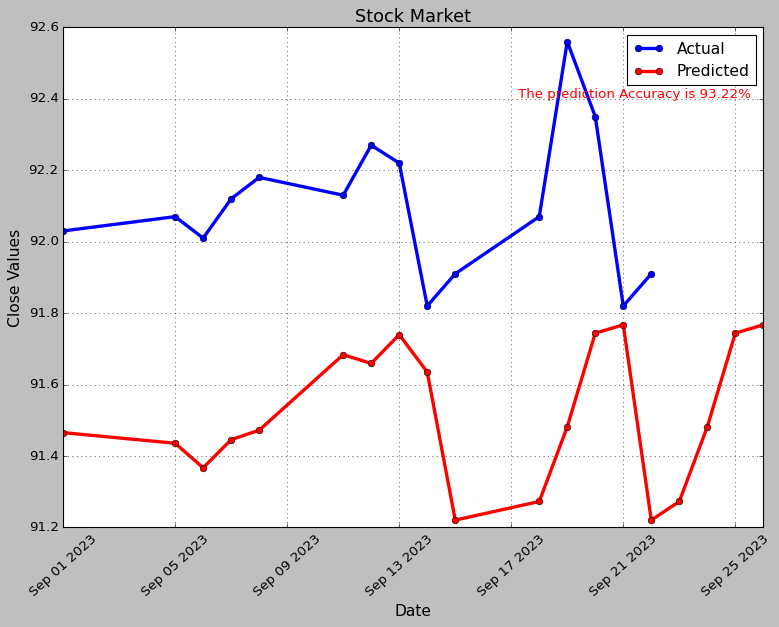

In [12]:
plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
plt.plot(Combined.loc["2023-09-01":f"{DATE}"].index,Combined.loc["2023-09-01":f"{DATE}","Actual"],"b-o",label="Actual",linewidth=3)
plt.plot(Combined.loc["2023-09-01":].index,Combined.loc["2023-09-01":,"Predicted"],"r-o",label="Predicted",linewidth=3)
plt.legend(loc="upper right",fontsize=14)
plt.xticks(rotation=42,)
Acc=r2_score(Combined["Actual"],Combined["Predicted"])
# Annotating a point
plt.grid()
plt.annotate(f"The prediction Accuracy is {round(Acc*100,2)}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.65, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)


plt.tight_layout()


In [13]:
Combined.tail(11)

,Actual,Predicted,Diff
2023-09-14,91.820000,91.634998,0.185002
2023-09-15,91.910004,91.220402,0.689602
2023-09-18,92.070000,91.272465,0.797535
2023-09-19,92.559998,91.481717,1.078281
2023-09-20,92.349998,91.743781,0.606217
2023-09-21,91.820000,91.767128,0.052872
2023-09-22,91.910004,91.220402,0.689602
2023-09-23,92.070000,91.272465,0.797535
2023-09-24,92.559998,91.481717,1.078281
2023-09-25,92.349998,91.743781,0.606217


C:\Users\nbana\OneDrive\Desktop\test\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


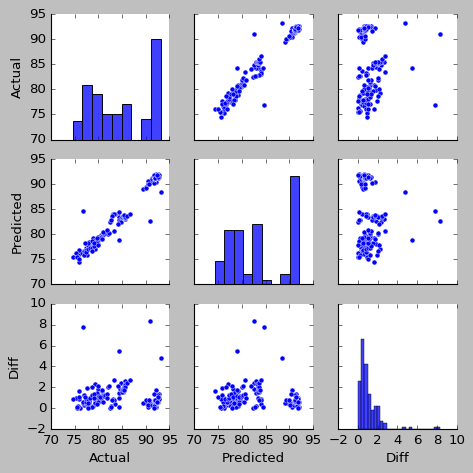

In [14]:
sns.pairplot(Combined,diag_kind="hist",height=2)

In [15]:
df.iloc[[-6,6]]

,open,high,low,close,adj close,volume,target
2023-09-21,92.410004,92.570000,92.290001,92.349998,92.349998,6026800,91.820000
2022-09-30,74.900002,75.300003,74.220001,74.339996,73.546585,9498200,74.360001
